<a href="https://colab.research.google.com/github/longhowlam/python_hobby_stuff/blob/master/GTST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goede Tijden Slechte Tijden 
Analysis of Dutch Soap series GTST

## Set up 

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!python -m spacy download nl
!pip install pyldavis

In [0]:
import pandas as pd
import seaborn as sns

import spacy
nlp = spacy.load("nl")

# Gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models.ldamodel import LdaModel
import pyLDAvis.gensim

## Import GTST summaries

In [0]:
gtst = pd.read_csv("/content/drive/My Drive/DataSets/GTST_Daily_data.csv")
gtst.sample(5)

,text_of_1month,datums,datums2
131,Rolf voorziet moeilijkheden nu zijn dochter o...,Dinsdag 2 april 1991,2 4 1991
3069,Nick wil weten waarom Charlie Jack heeft gesl...,Woensdag 7 februari 2007,7 2 2007
3831,Rikki wil van Sjoerd weten of de zoen een gra...,Vrijdag 8 april 2011,8 4 2011
529,"Daniël, Marieke en Suzanne krijgen ongewenst ...",Donderdag 22 april 1993,22 4 1993
4011,Nuran geeft toe aan wat ze echt voor Danny vo...,Maandag 13 februari 2012,13 2 2012


In [0]:
gtst = gtst.assign(
    datums2 = gtst.datums2.str.lstrip(),
    datum = lambda x: pd.to_datetime(x['datums2'], format='%d %m %Y', errors = "coerce")
)

## NLP Stuff

### Count the number of PERSONS found in a text
Use SpaCy to find entiies, and in our case PERSONS (PER)

In [0]:
def count_persons(text):
  doc = nlp(text)
  return list(map(lambda x: x.label_, doc.ents)).count('PER')

In [0]:
count_persons(gtst.text_of_1month[300])

In [0]:
%%time
gtst = (
    gtst
    .assign(
        n_persons = gtst.text_of_1month.apply(count_persons)
    )
) 

CPU times: user 58.4 s, sys: 80.4 ms, total: 58.5 s
Wall time: 58.5 s


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


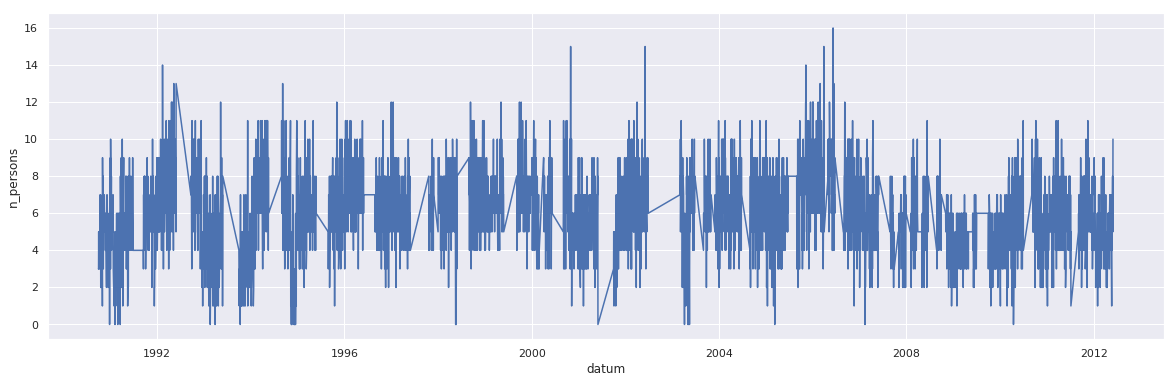

In [0]:
sns.set(rc={'figure.figsize':(20,6)})
sns.lineplot(x="datum", y = "n_persons", data = gtst)

In [0]:
!pip install calmap

In [0]:
events = pd.Series(gtst.n_persons.ravel(), index = gtst.datum.ravel())

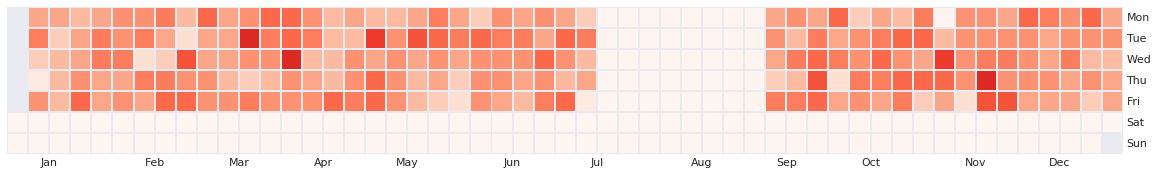

In [0]:
import calmap
calmap.yearplot(events, year=2011)


## Topic Modeling


### Clean the texts

In [0]:
def clean_review(x):
    doc = nlp(x)
    tokens = [token.text for token in doc if (not token.is_punct) & (not token.is_stop)]
    return " ".join(tokens)
  
review_sample = (
    gtst
    .assign(
        cleaned_review = gtst.text_of_1month.apply(clean_review)
    )
)  

### Tokenize

In [0]:
from pprint import pprint
from collections import defaultdict

# remove common words and tokenize
nlstop = spacy.lang.nl.stop_words.STOP_WORDS
texts = [
    [word for word in document.lower().split() if word not in nlstop]
    for document in review_sample.cleaned_review
]

# remove words that appear only once
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

texts = [
    [token for token in text if frequency[token] > 1]
    for text in texts
]

### Create dictionary and corpus

In [37]:
dictionary = corpora.Dictionary(texts)
print(dictionary)
corpus = [dictionary.doc2bow(text) for text in texts]

Dictionary(5091 unique tokens: ['alberts', 'arnie', 'doktersadvies', 'helen', 'helmink']...)


### create topic model

In [0]:
%%time
review_lda = LdaModel(corpus, num_topics = 16, id2word = dictionary, passes = 10)

In [40]:
review_lda_topics = review_lda.print_topics(num_topics=16 )
review_lda_topics

[(0,
  '0.037*"neemt" + 0.019*"valt" + 0.019*"\'s" + 0.016*"komen" + 0.015*"valerie" + 0.015*"laura" + 0.014*"werkt" + 0.013*"gaan" + 0.012*"serieus" + 0.012*"zet"'),
 (1,
  '0.031*"danny" + 0.031*"ludo" + 0.028*"grote" + 0.021*"janine" + 0.020*"verrassing" + 0.018*"zoekt" + 0.016*"rik" + 0.015*"verleden" + 0.014*"waarheid" + 0.011*"ruzie"'),
 (2,
  '0.026*"peter" + 0.023*"simon" + 0.021*"arnie" + 0.021*"helen" + 0.019*"affaire" + 0.016*"frits" + 0.015*"suzanne" + 0.015*"delen" + 0.015*"daniël" + 0.014*"\'s"'),
 (3,
  '0.037*"dennis" + 0.027*"rik" + 0.027*"ergert" + 0.025*"lijnrecht" + 0.022*"bing" + 0.021*"lorena" + 0.019*"zet" + 0.019*"sjors" + 0.018*"denken" + 0.018*"saskia"'),
 (4,
  '0.041*"krijgt" + 0.036*"nina" + 0.029*"danny" + 0.029*"rik" + 0.023*"hulp" + 0.019*"nuran" + 0.017*"vindt" + 0.017*"probeert" + 0.016*"aysen" + 0.016*"nodig"'),
 (5,
  '0.036*"nina" + 0.031*"jack" + 0.023*"probeert" + 0.021*"nuran" + 0.020*"bing" + 0.020*"ontdekt" + 0.019*"sjors" + 0.018*"bekentenis" 

In [41]:
vis_data = pyLDAvis.gensim.prepare(review_lda, corpus, dictionary)
pyLDAvis.display(vis_data)

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))
